# Polynomial Regression Model

This is potentially one of the best models that could give us what we want. Because as it states in the name, this time it fits polynomials. Thus it should be able to capture the square-sum relations.

In [11]:
import sys
import os
import numpy as np
import pandas as pd

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data
from hypotai.models.model_LR import train_linear_model
from hypotai.models.model_PR import train_polynomial_model
from hypotai.plotting import plot_regression_surface

from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
df = generate_triangle_data(n_samples=100_000, angle_mode="right")         # < ------ Right triangle data
df_random = generate_triangle_data(n_samples=100_000, angle_mode="random") # < ------ Random triangle data

In [3]:
modelLR_noangles, metricsLR = train_linear_model(df_random)  # < ------ Train linear model without angles
modelLR_angles, metricsLR_angles = train_linear_model(df_random, include_angles=True)  # < ------ Train linear model without angles

Now let's include polynomial features.

In [4]:
from sklearn.preprocessing import PolynomialFeatures
## this is actually just a conversion of the data to polynomial features that can still be treated as linear regression
poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(df_random[["a", "b"]])

What this does is instead of fitting the linear model like this $$ \hat{c} = w_0 + w_1 a + w_2 b$$, it now fits $$\hat{c} = w_0 + w_1 a + w_2 b + w_3 a^2 + w_4 ab + w_5 b^2$$ notice that this is still liinear, we just represent the two values with more variables that correspond to their higher powers.

This is basically a Taylor expansion.

In [5]:
df_random[["a", "b"]].iloc[:2]

,a,b
0,77.418209,93.893436
1,43.943956,94.767465


In [6]:
X_poly[:2]

array([[  77.41820925,   93.89343621, 5993.57912359, 7269.06169203,
        8815.97736393],
       [  43.94395613,   94.76746508, 1931.07128046, 4164.4573283 ,
        8980.87243836]])

### Now let's fit the transformed data

In [7]:
# Same as before, this time with polynomial features
modelPR_noangles, metricsPR = train_polynomial_model(df_random)                     # < ------ Train linear model without angles
## Note, here if we have angles, we can still get polynomial features 
# but we need to get them for the a,b and then add the angles separately
modelPR_angles, metricsPR_angles = train_polynomial_model(df_random, include_angles=True)  # < ------ Train linear model without angles

In [8]:
### Look at the metrics
print("Linear Regression without angles:", metricsLR)
print("Linear Regression with angles:", metricsLR_angles)
print("Polynomial Regression without angles:", metricsPR)
print("Polynomial Regression with angles:", metricsPR_angles)

Linear Regression without angles: {'mse': 784.1267063625083, 'r2': 0.4466877244249343}
Linear Regression with angles: {'mse': 305.0825681037607, 'r2': 0.7847211061349358}
Polynomial Regression without angles: {'mse': 719.0912770860599, 'r2': 0.4925794165124078}
Polynomial Regression with angles: {'mse': 240.14789935038095, 'r2': 0.8305416974247258}


Again, as expected. Not giving the angles for the training is a terrible thing to do. <br>
If you compare the Linear Regression with angles to Polynomial Regression with angles it is clear that Polynomial Regression rules.

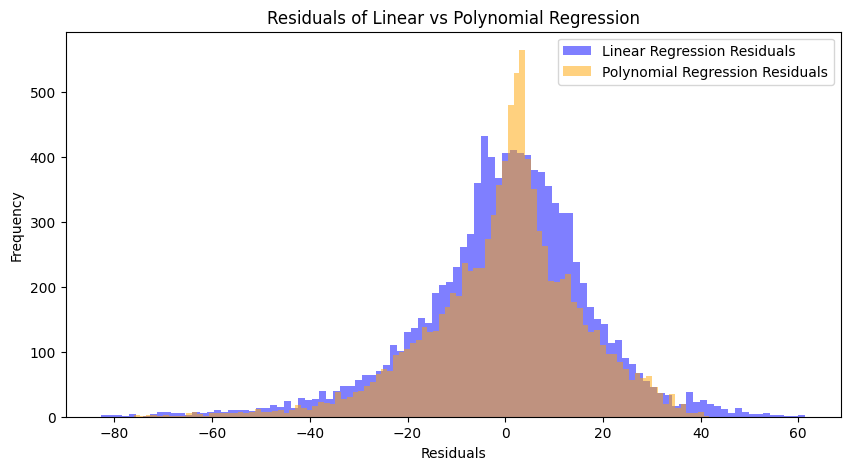

In [17]:
new_data = generate_triangle_data(n_samples=10_000, angle_mode="random")
Xnew, ynew = new_data[["a", "b", "angle_deg"]], new_data["c"]

fit_linear = modelLR_angles.predict(Xnew)

# Transform the new data using the polynomial features
_X_poly_new = PolynomialFeatures(degree=2).fit_transform(Xnew[["a", "b"]])
X_poly_new = np.concatenate([_X_poly_new, Xnew[["angle_deg"]].values], axis=1)
fit_poly = modelPR_angles.predict(X_poly_new)

plt.figure(figsize=(10, 5))
plt.hist(ynew-fit_linear, bins=100, alpha=0.5, label="Linear Regression Residuals", color="blue")
plt.hist(ynew-fit_poly, bins=100, alpha=0.5, label="Polynomial Regression Residuals", color="orange")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals of Linear vs Polynomial Regression")
plt.legend()
plt.show()

Nice! The polynomial model is doing a lot better job. <br>


Let's see what happens if we only use 90-degree triangles!

### Only right-angled triangles

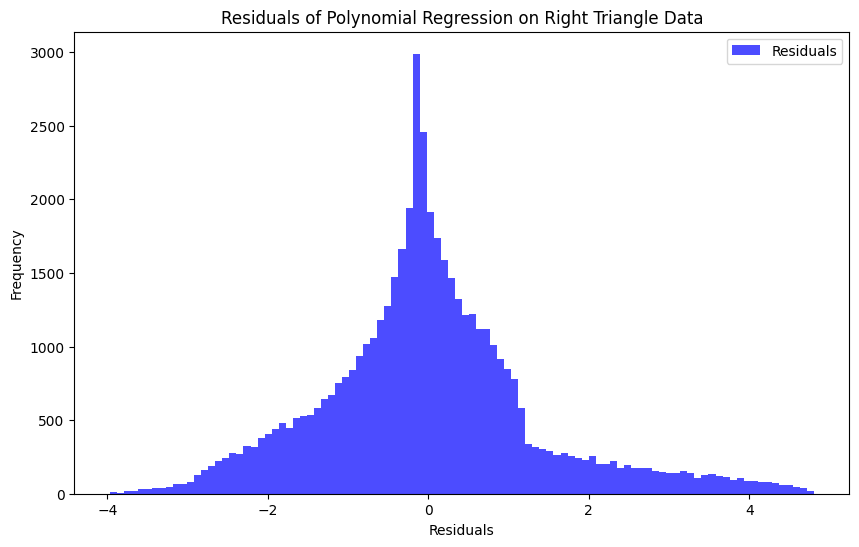

In [24]:
df = generate_triangle_data(n_samples=100_000, angle_mode="right")
model_PR, metricsPR = train_polynomial_model(df)

df_test = generate_triangle_data(n_samples=50_000, angle_mode="right")
X_test, y_test = df_test[["a", "b"]], df_test["c"]
X_poly_test = PolynomialFeatures(degree=2).fit_transform(X_test[["a", "b"]])
y_pred = model_PR.predict(X_poly_test)
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, alpha=0.7, label="Residuals", bins=100, color="blue")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals of Polynomial Regression on Right Triangle Data")
plt.legend()

Notice that the form $$c = \sqrt{a^2 + b^2}$$ is still not polynomial. We can increase the degree of polynomial expension and try to a little better.

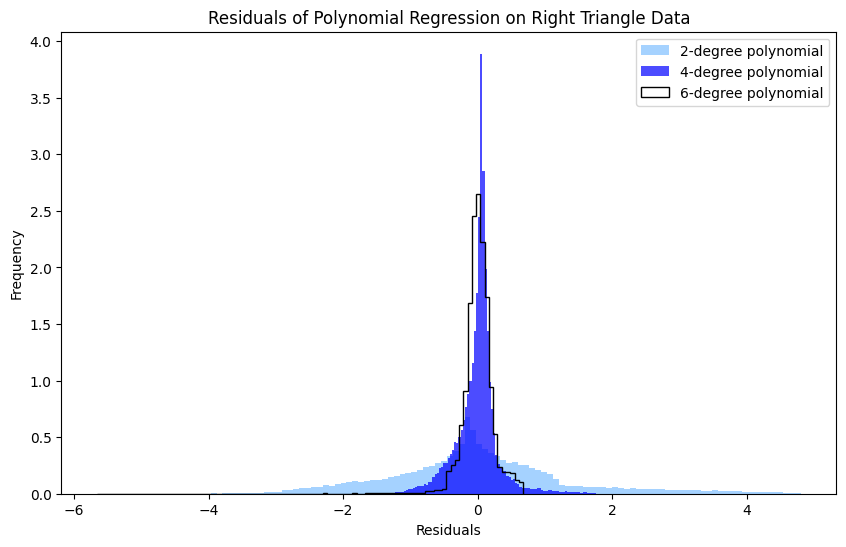

In [28]:
model_PR4, metricsPR4 = train_polynomial_model(df, degree=4)
X_poly_test4 = PolynomialFeatures(degree=4).fit_transform(X_test[["a", "b"]])
y_pred4 = model_PR4.predict(X_poly_test4)

model_PR6, metricsPR6 = train_polynomial_model(df, degree=6)
X_poly_test6 = PolynomialFeatures(degree=6).fit_transform(X_test[["a", "b"]])
y_pred6 = model_PR6.predict(X_poly_test6)


plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, alpha=0.4, label="2-degree polynomial", bins=100, color="dodgerblue", density=True)
plt.hist(y_test - y_pred4, alpha=0.7, label="4-degree polynomial", bins=100, color="blue", density=True)
plt.hist(y_test - y_pred6, alpha=1, label="6-degree polynomial", bins=100, color="k", histtype='step', density=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals of Polynomial Regression on Right Triangle Data")
plt.legend()

So with a higher degree polynomial you can fit better and better. However, one should be careful, sometimes you want to be "generic" and not nicely fit on one specific dataset. Also known as "Overfitting", also known as "with enough parameters you can fit an elephant".